# Module Association with Cell Proportion

**Created**: 14 October 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("xCell")) {
    library(remotes)
    install_github("dviraran/xCell")
}

Loading required namespace: patchwork

Loading required namespace: xCell




RSQLite      (2.2.8  -> 2.2.9 ) [CRAN]
BiocGenerics (0.36.0 -> 0.36.1) [CRAN]
xtable       (NA     -> 1.8-4 ) [CRAN]
graph        (NA     -> 1.68.0) [CRAN]
annotate     (NA     -> 1.68.0) [CRAN]
GenomeInfoDb (1.26.4 -> 1.26.7) [CRAN]
GSEABase     (NA     -> 1.52.1) [CRAN]
quadprog     (NA     -> 1.5-8 ) [CRAN]
pracma       (NA     -> 2.3.6 ) [CRAN]
GSVA         (NA     -> 1.38.2) [CRAN]


Installing 10 packages: RSQLite, BiocGenerics, xtable, graph, annotate, GenomeInfoDb, GSEABase, quadprog, pracma, GSVA



✔  checking for file ‘/tmp/Rtmp94bal1/remotese184602c433e/dviraran-xCell-7339410/DESCRIPTION’
─  preparing ‘xCell’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘xCell_1.1.0.tar.gz’
   


In [2]:
library(tidyverse)
library(RColorBrewer)
library(patchwork)
library(xCell)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Load Data

In [39]:
gene.exp <- read.table("/lustre/scratch119/humgen/projects/gains_team282/eqtl/data/logcpm_864_20412_hla.txt")
gene.info <- read.table("/nfs/team282/data/gains_team282/Gene_info_864_20416.txt")

In [40]:
head(gene.exp)

,UK02270173_3,UK15130120_3,UK58000006_3,UK47010004_3,UK42020088_5,UK47490007_3,UK02770164_3,UK02770164_5,UK02630151_3,UK42150107_1,⋯,UK59070043_3,UK59070043_5,UK02510223_3,UK02XX0336_5,UK29090086_3,UK02XX0335_1,UK02XX0334_3,UK01210130_3,UK01210130_5,UK01380125_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000230521,0.6644339,0.58271604,0.4046756,0.20905157,0.2211571,0.4288519,0.5133516,0.57768877,0.6990766,0.3812037,⋯,0.3823184,0.5423684,0.86762630,0.73833461,0.6461583,0.1227063,0.9621386,0.65838459,1.03561474,0.4457301
ENSG00000225864,0.9817872,0.43879936,0.6022344,0.92340489,0.2211571,1.1450686,0.1921362,0.57768877,0.1974851,1.2290495,⋯,0.6842527,0.8539227,0.91886777,0.12581620,0.5511865,0.4384007,0.5465139,0.40803066,0.46899151,0.3544115
ENSG00000227766,1.2117156,0.30682669,0.6625010,0.79963286,0.6445686,0.3130290,0.1183231,0.16750450,0.1505900,1.0533199,⋯,0.4901384,0.4340781,0.37504164,0.04316943,0.6151905,0.3406488,0.3147798,0.43511377,0.17382742,0.1157514
ENSG00000237669,0.6420763,0.69256830,0.9792012,0.69929584,0.3765156,1.0756817,0.8912050,0.60129641,0.8534668,1.0533199,⋯,1.0790156,0.6102946,1.03953331,0.97965846,0.7061683,0.7489857,0.7919934,0.85168813,0.69120049,1.0798771
ENSG00000271581,2.4744895,1.33153140,1.8310464,2.47531701,1.8812042,2.0531366,0.5972544,1.00686213,1.2811361,2.4244938,⋯,2.4728831,1.5338898,1.59080138,0.62923925,1.2804253,1.4727511,1.2187650,1.46471386,1.44139443,1.1896250
ENSG00000285647,0.0000000,0.03379072,0.0000000,0.05517067,0.6748270,0.0000000,0.0000000,0.03509293,0.6990766,1.6556266,⋯,3.4117627,2.4012963,0.04682116,0.00000000,0.0000000,0.4695662,0.3762952,0.07078527,0.07206309,0.4159282


Some patient identifiers may have a GA- prefix that has been dropped in future releases of the data. If this identifier exists, I drop the prefix.

In [41]:
head(gene.info)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,protein_id,protein_version,ccds_id
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1248375,X,100627108,100639991,12884,-,ensembl_havana,gene,NA,NA,ENSG00000000003,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2612838,20,50934867,50958555,23689,-,ensembl_havana,gene,NA,NA,ENSG00000000419,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
198068,1,169849631,169894267,44637,-,ensembl_havana,gene,NA,NA,ENSG00000000457,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
197489,1,169662007,169854080,192074,+,ensembl_havana,gene,NA,NA,ENSG00000000460,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
46865,1,27612064,27635185,23122,-,ensembl_havana,gene,NA,NA,ENSG00000000938,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
213754,1,196652043,196747504,95462,+,ensembl_havana,gene,NA,NA,ENSG00000000971,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [42]:
ga.prefix.filter <- grepl("GA", rownames(gene.exp))

rownames(gene.exp)[ga.prefix.filter] <- gsub("^GA", "", rownames(gene.exp)[ga.prefix.filter])

In [43]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv", row.names=1)
variance.explained <- read.csv("~/gains_team282/nikhil/expression/gene_expression/variance.explained.csv")

In [44]:
head(eigengenes)

,ME_1,ME_2,ME_3,ME_4,ME_5,ME_6,ME_7,ME_8,ME_9,ME_10,⋯,ME_57,ME_58,ME_59,ME_60,ME_61,ME_62,ME_63,ME_64,ME_65,ME_66
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UK02270173_3,-0.007334113,-0.012539535,0.019766245,0.002754747,0.017331897,-0.03308963,0.037551543,0.035526167,0.007061637,-0.045462098,⋯,-0.03736851,-0.015491299,-0.0003944539,0.011723160,0.02044694,0.036389792,-0.0199594898,-0.0137973687,-0.0226533146,-0.0224921394
UK15130120_3,-0.039218201,-0.028118430,-0.030119369,0.044385750,-0.035924531,-0.01776018,0.048988451,0.032309702,-0.025540316,-0.003352967,⋯,0.03449182,0.009217925,-0.0089077866,0.051934721,0.02981843,-0.012103471,0.0152503786,-0.0008924039,0.0005244192,0.0670088144
UK58000006_3,0.016278695,0.002300409,0.038062533,-0.019970003,0.035664412,-0.02460794,-0.013427286,0.025928161,0.019651683,-0.049510956,⋯,0.03616406,0.004048221,0.0298820001,-0.029996760,0.01875794,-0.009576244,-0.0324318003,0.0003237006,-0.0110317401,-0.0327675701
UK47010004_3,0.012015980,0.022969179,-0.004106886,-0.018628648,0.023430789,0.01904802,0.002796251,-0.011522015,-0.009007830,-0.001991980,⋯,0.02905445,-0.020687733,-0.0147508943,0.001036775,-0.01651732,0.030270486,-0.0053783817,0.0314069529,-0.0060826198,-0.0201014546
UK42020088_5,0.014862024,0.025478183,-0.004896746,-0.002020827,0.001845234,0.02344584,-0.004351176,-0.008517141,0.008746174,0.024165915,⋯,0.03286665,0.001720939,-0.0042298661,-0.010538437,-0.02148751,0.064750526,-0.0006839132,-0.0057871254,0.0119033593,0.0007013236
UK47490007_3,-0.018282178,0.014805866,-0.041274648,0.015737059,-0.004421347,0.03830728,0.003762546,-0.023246260,-0.045245113,0.030086125,⋯,0.02577557,-0.016313161,-0.0323697955,0.016932273,0.02380263,0.035666094,0.0028921852,0.0335825353,0.0320275167,-0.0150428658


In [45]:
sample.info <- read.table("/nfs/team282/data/gains_team282/Sample_info_864.txt")
ga.prefix.filter <- grepl("GA", sample.info$supplier_name)
sample.info$supplier_name[ga.prefix.filter] <- gsub("^GA", "", sample.info$supplier_name[ga.prefix.filter])
sample.info <- sample.info %>% 
  dplyr::filter(supplier_name %in% rownames(eigengenes))
rownames(sample.info) <- sample.info$supplier_name
sample.info <- sample.info[rownames(eigengenes),]

In [46]:
head(sample.info)

,manual_qc,id_study_lims,name,description,sanger_sample_id,supplier_name,last_updated,id_library_lims,id_pool_lims,id_iseq_flowcell_tmp,⋯,TIN.mean.,TIN.median.,TIN.stdev.,Concentration,num_samples_per_lane,SRSUnsup,globin_rate_fromcounts,PCOutlier,OtherOutlier,GAinSID
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<lgl>,<lgl>,<chr>
UK02270173_3,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032857,UK02270173_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930558,⋯,69.51307,76.82800,23.72743,116.731,77,2,0.6790401,FALSE,FALSE,UK02270173
UK15130120_3,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032858,UK15130120_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930559,⋯,65.03706,71.49895,24.13243,76.185,77,2,0.6826886,FALSE,FALSE,UK15130120
UK58000006_3,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032859,UK58000006_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930560,⋯,70.85535,78.07773,23.24183,59.767,77,2,1.4290063,FALSE,FALSE,UK58000006
UK47010004_3,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032860,UK47010004_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930561,⋯,68.16224,75.05450,23.56361,105.000,77,1,0.9177558,FALSE,FALSE,UK47010004
UK42020088_5,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032861,UK42020088_5,2019-09-30 21:01:38,DN548016D,NT1557159B,6930562,⋯,64.67378,72.53810,26.03766,87.843,77,1,0.4031685,FALSE,FALSE,UK42020088
UK47490007_3,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032862,UK47490007_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930563,⋯,62.79935,68.60305,24.27960,67.484,77,2,1.1993500,FALSE,FALSE,UK47490007


In [47]:
srs.info <- read.table("/nfs/team282/data/gains_team282/full-gains-SRS-predictions_mNN-RF.tsv", header=T)
ga.prefix.filter <- grepl("GA", srs.info$Sample_id)
srs.info$Sample_id[ga.prefix.filter] <- gsub("^GA", "", srs.info$Sample_id[ga.prefix.filter])
srs.info <- srs.info %>%
  dplyr::filter(Assay=="RNA-seq")
row.names(srs.info) <- srs.info$Sample_id
srs.info <- srs.info[rownames(eigengenes),]

In [48]:
cell.prop <- read.table("04_Expression/data/gene_expression/Cell_props_864.txt", header=TRUE)
ga.prefix.filter <- grepl("GA", cell.prop$Sample)
cell.prop$Sample[ga.prefix.filter] <- gsub("^GA", "", cell.prop$Sample[ga.prefix.filter])
rownames(cell.prop) <- cell.prop$Sample
cell.prop <- cell.prop[rownames(eigengenes),]

In [49]:
head(cell.prop)

,Sample,GAinSID,Day,Neutrophils,Lymphocytes,Monocytes
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
UK02270173_3,UK02270173_3,UK02270173,3,0.8000000,0.11000000,0.09000000
UK15130120_3,UK15130120_3,UK15130120,3,NA,NA,NA
UK58000006_3,UK58000006_3,UK58000006,3,0.8875740,0.06508876,0.04733728
UK47010004_3,UK47010004_3,UK47010004,3,0.8813559,0.06779661,0.05084746
UK42020088_5,UK42020088_5,UK42020088,5,0.8857143,0.07857143,0.03571429
UK47490007_3,UK47490007_3,UK47490007,3,0.9183673,0.05102041,0.03061224


Data from Aran *et al.* on xCell cell type groups and subgroups.

In [83]:
xcell.info <- read.csv("04_Expression/data/xCell_Aran_et_al_Additional_File_1.csv")

In [84]:
head(xcell.info)

,Full.name,Cell.types,FANTOM5,ENCODE,Blueprint,IRIS,Novershtern,HPCA,X..of.sources,X..of.samples,Group,Subgroup,Parent.Child
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
1,Monocytes,Monocytes,42,0,16,12,5,66,5,141,Non-lymphocytes,Myeloid,Parent
2,CD8+ T-cells,CD8+ T-cells,11,0,3,4,7,16,5,41,Lymphocytes,Lymphoid,Parent
3,NK cells,NK cells,3,0,3,15,6,5,5,32,Lymphocytes,Lymphoid,Parent
4,Macrophages,Macrophages,27,0,18,12,0,59,4,116,Non-lymphocytes,Myeloid,Parent
5,Endothelial cells,Endothelial cells,22,14,4,0,0,48,4,88,Non-Hematopoietic,Stroma,Parent
6,Dendritic cells,DC,4,0,1,6,0,45,4,56,Non-lymphocytes,Myeloid,Parent


## Association with SRSq

Built a correlation matrix comparing module eigengenes with SRSq for samples.

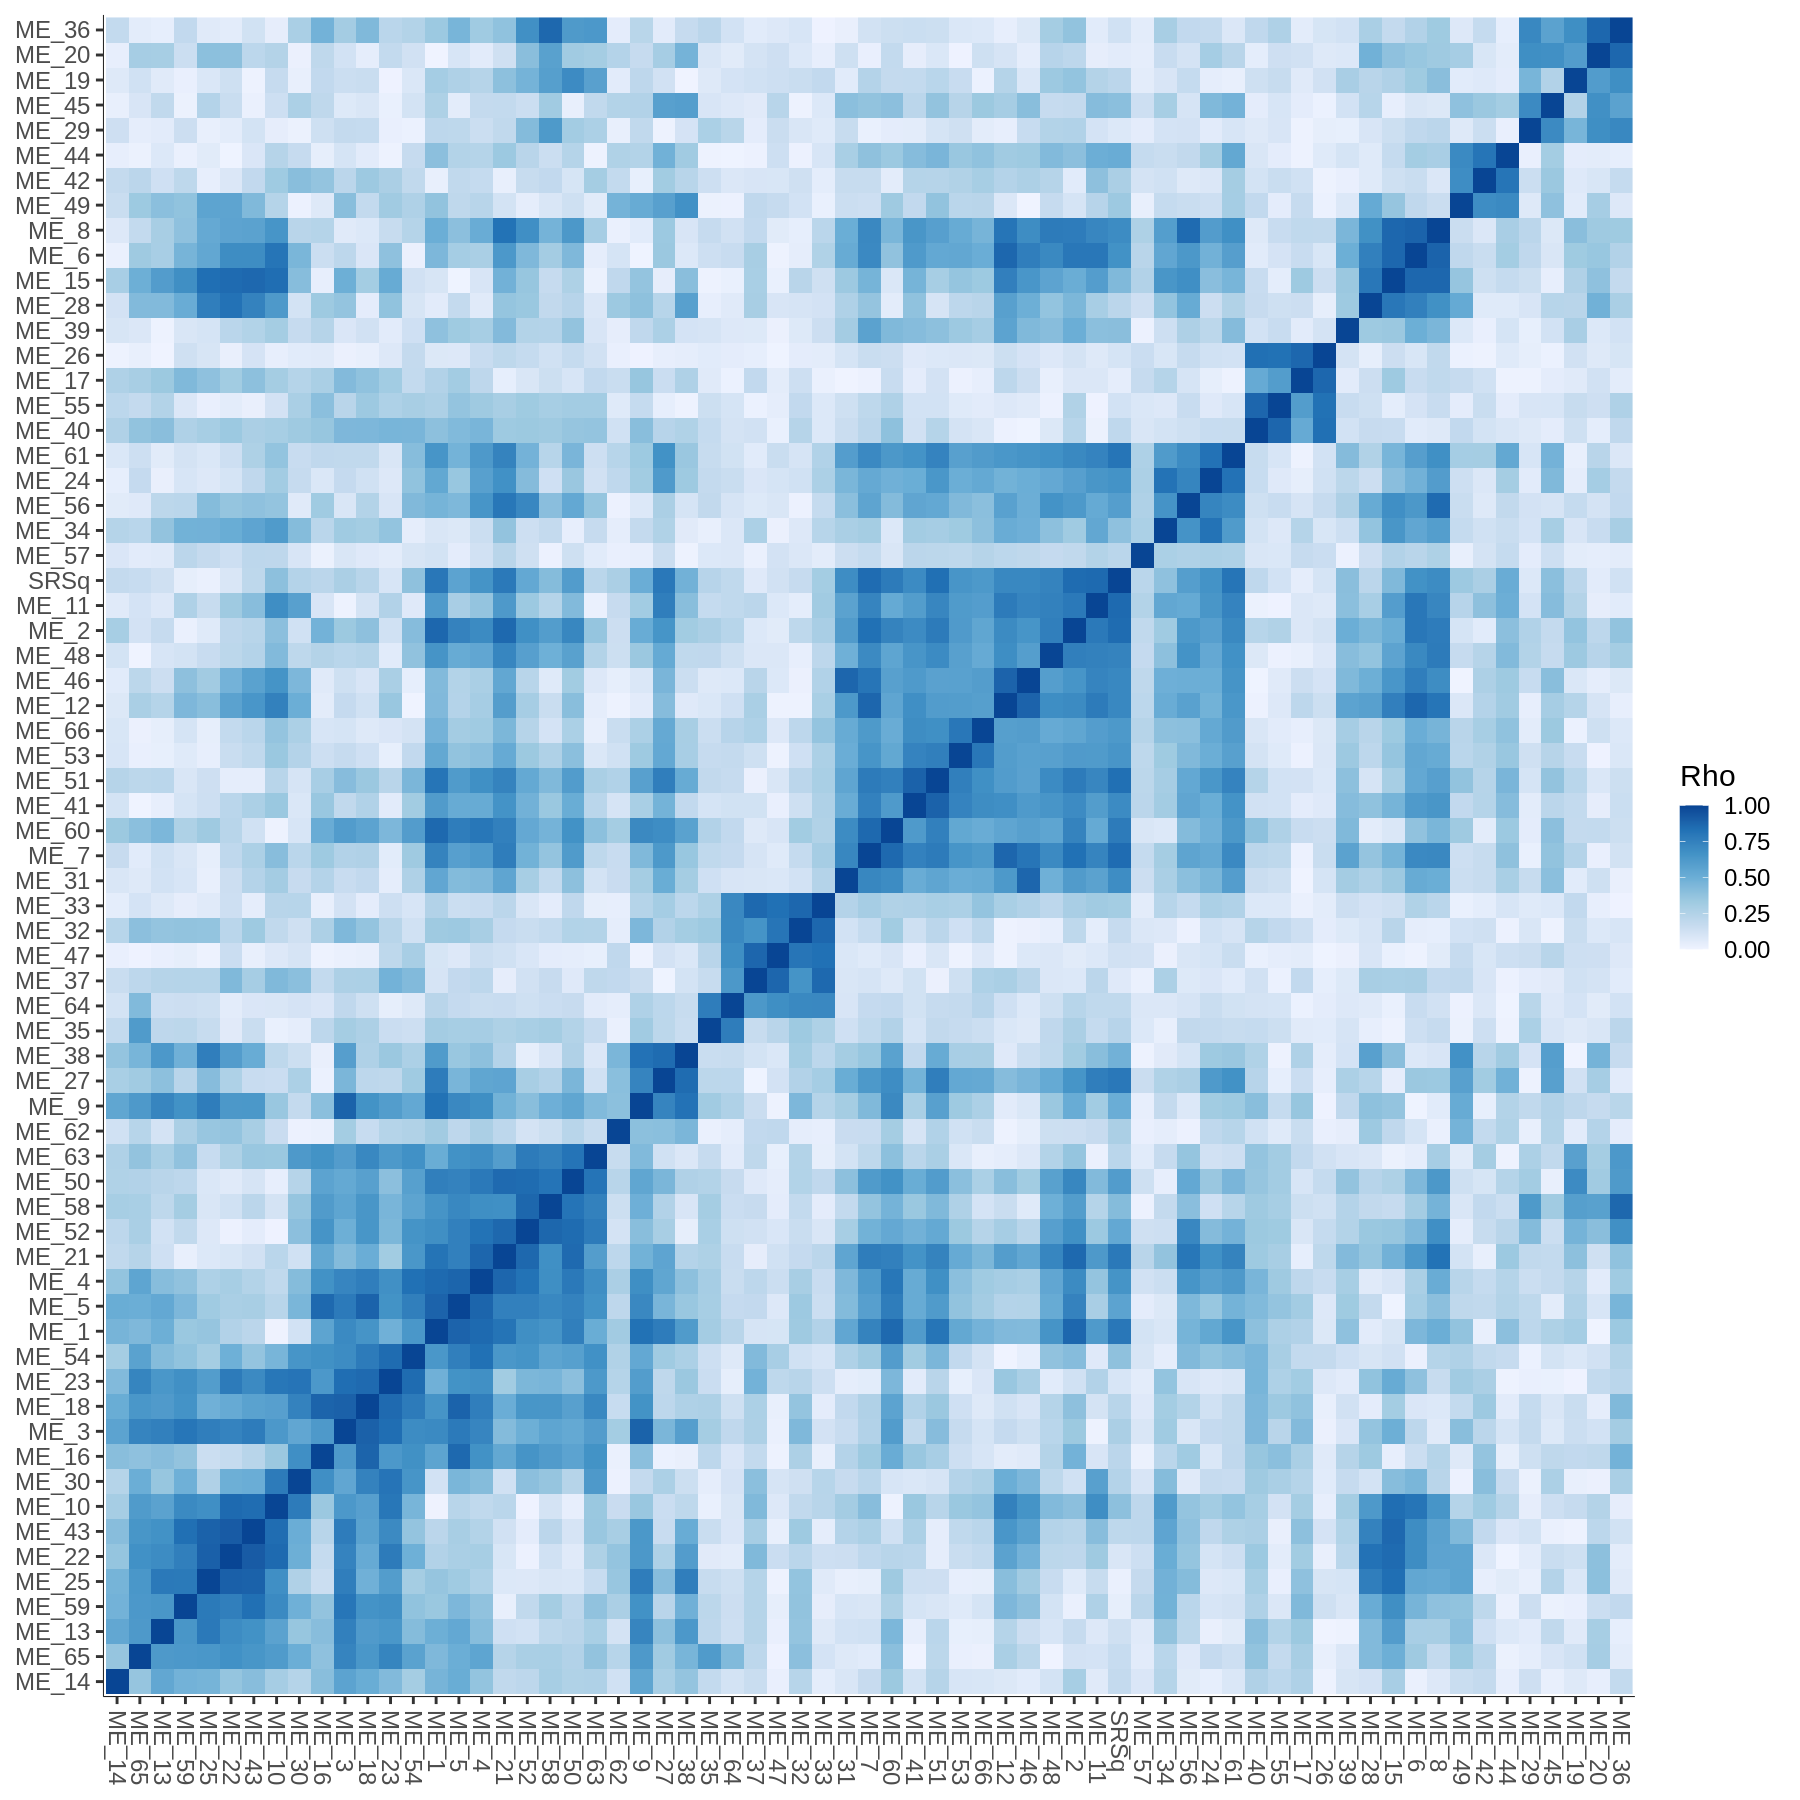

In [53]:
variables <- cbind(eigengenes, srs.info$SRSq)
colnames(variables)[ncol(variables)] <- "SRSq"

rho.values <- abs(cor(variables, method="spearman", use="pairwise.complete.obs"))

rho.values.hclust <- hclust(as.dist(1 - rho.values))

options(repr.plot.width=15, repr.plot.height=15)
rho.values %>%
  as.data.frame() %>%
  dplyr::mutate(Variable.2=rownames(.)) %>%
  tidyr::gather("Variable.1", "Rho", -Variable.2) %>%
  dplyr::mutate(Variable.1=factor(Variable.1, levels=colnames(rho.values)[rho.values.hclust$order])) %>%
  dplyr::mutate(Variable.2=factor(Variable.2, levels=colnames(rho.values)[rho.values.hclust$order])) %>%
  ggplot() +
  geom_raster(aes(x=Variable.1, y=Variable.2, fill=Rho)) +
  scale_fill_distiller(palette="Blues", limits=c(0, 1), direction=1) +
  ggplot_theme +
  theme(axis.title=element_blank(), axis.text.x=element_text(angle=270, vjust=0.5, hjust=0), legend.position="right")
ggsave("04_Expression/results/eigengene_association_with_srsq.svg", width=15, height=15)

Performed significance tests for correlation for Spearman's $\rho$. A significance compares the null hypothesis that $\rho=0$ versus the alternate that $\rho\neq 0$. I use Benjamini-Hochberg p-value adjustment to control for the False Discovery Rate.

In [54]:
estimates <- lapply(colnames(eigengenes), function(eigengene.name) {
  test.result = cor.test(srs.info$SRSq, eigengenes[,eigengene.name], alternative="two.sided", method="spearman", exact=FALSE)
  return(c(test.result$estimate, test.result$p.value))
}) %>%
  do.call(rbind, .) %>%
  as.data.frame() %>%
  dplyr::select(Rho=1, P.Value=2) %>%
  dplyr::mutate(Eigengene=colnames(eigengenes)) %>%
  dplyr::arrange(desc(abs(Rho))) %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::mutate(Association.Variable="SRSq", Association.Variable.Type="SRSq", Statistic.Type="Rho") %>%
  dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=Rho, Statistic.Type, P.Value, Adjusted.P.Value)

write.csv(estimates, "~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.srsq.association.csv")

Since a significant result does not necessarily imply a large effect size, I visualize module eigengenes that are significantly associated with SRSq and also have a large effect size ($|\rho|\geq 0.8$).

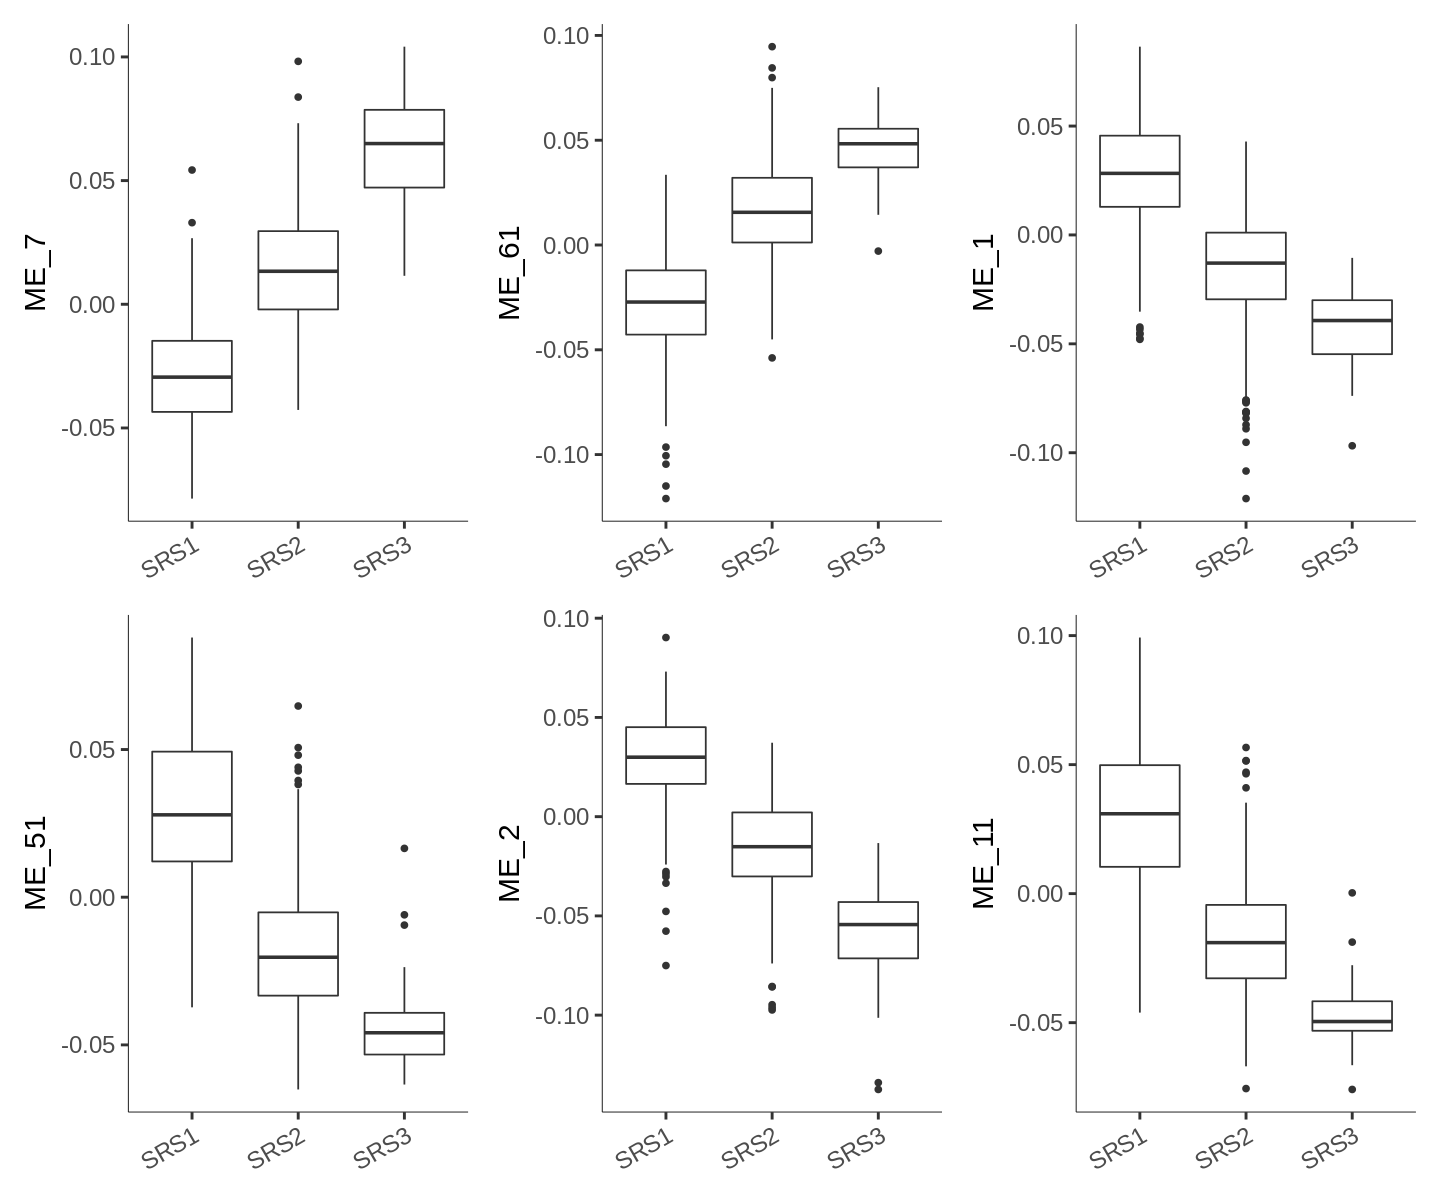

In [55]:
estimates <- estimates %>%
  dplyr::filter(abs(Statistic) >= 0.8, Adjusted.P.Value < 0.05) %>%
  dplyr::arrange(Statistic) %>%
  dplyr::mutate(Eigengene=factor(Eigengene, levels=Eigengene))

# Plot Associated Eigengenes by SRS Group

plots <- lapply(estimates$Eigengene, function(eigengene.name) {
  cbind(srs.info$SRS, eigengenes) %>%
    as.data.frame() %>%
    dplyr::select(SRS=1, everything()) %>%
    ggplot(aes_string(x="SRS", y=as.character(eigengene.name))) +
    geom_boxplot() +
    ggplot_theme +
    theme(axis.title.x=element_blank(), axis.text.x=element_text(angle=30, hjust=1))
})

options(repr.plot.width=12, repr.plot.height=10)
wrap_plots(plots)
ggsave("04_Expression/results/eigengene_association_with_srs_group.svg", width=12, height=10)

## Association with Cell Proportion

Relative cell proportions were measured for most of the samples that have transcriptomic data. There is a large expansion of inflammatory cells during sepsis (especially neutrophils). Similar to SRSq, I perform a significance test for association with Spearman's $\rho$ and adjust p-values using the Benjamini-Hochberg FDR correction.

In [56]:
cell.prop.vars <- cell.prop[,c("Neutrophils", "Lymphocytes", "Monocytes")]

estimates <- lapply(colnames(eigengenes), function(eigengene.name) {
    lapply(colnames(cell.prop.vars), function(cell.type) {
      test.result = cor.test(cell.prop.vars[,cell.type], eigengenes[,eigengene.name], alternative="two.sided", method="spearman", exact=FALSE)
      return(c(test.result$estimate, test.result$p.value, cell.type))
    }) %>%
      do.call(rbind, .) %>%
      as.data.frame() %>%
      dplyr::mutate(Eigengene=eigengene.name)
}) %>%
  do.call(rbind, .) %>%
  as.data.frame() %>%
  dplyr::select(Rho=1, P.Value=2, Association.Variable=3, Eigengene) %>%
  dplyr::mutate(Rho=as.numeric(Rho), P.Value=as.numeric(P.Value)) %>%
  dplyr::arrange(desc(abs(Rho))) %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::mutate(Association.Variable.Type="Cell Proportion", Statistic.Type="Rho") %>%
  dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=Rho, Statistic.Type, P.Value, Adjusted.P.Value)

write.csv(estimates, "~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.cell.proportion.association.csv")

## Association with xCell Scores

xCell assigns enrichment scores to samples based on their transcriptomic profiles. xCell derives signatures of specific primary cell types from large consortium datasets.

In [57]:
gene.map <- data.frame(
  Ensembl.ID=rownames(gene.exp)
)

gene.map <- merge(gene.map, gene.info, by.x="Ensembl.ID", by.y="gene_id")
rownames(gene.map) <- gene.map$Ensembl.ID

# Remove genes with duplicate gene names
duplicated.genes <- gene.map$gene_name[duplicated(gene.map$gene_name)]
gene.map <- gene.map %>%
  dplyr::filter(!(gene_name %in% duplicated.genes))

# Remove genes without gene information
xcell.exp <- gene.exp[gene.map$Ensembl.ID,]
rownames(xcell.exp) <- gene.map$gene_name

xcell.analysis <- xCellAnalysis(xcell.exp)

[1] "Num. of genes: 8708"


Warning message in .gsva(expr, mapped.gset.idx.list, method, kcdf, rnaseq, abs.ranking, :
“Some gene sets have size one. Consider setting 'min.sz > 1'.”


Setting parallel calculations through a MulticoreParam back-end
with workers=4 and tasks=100.
Estimating ssGSEA scores for 488 gene sets.
  |======================================================================| 100%



I tested for significant association between cell proportions and xCell scores using Spearman's $\rho$ and adjust p-values using the Benjamini-Hochberg FDR correction. I expect the neutrophil, monocyte, and lymphocyte proportions to be associated with xCell scores for granulocytes/neutrophils, B/T/NK lymphocytes, and monocyte/macrophages.

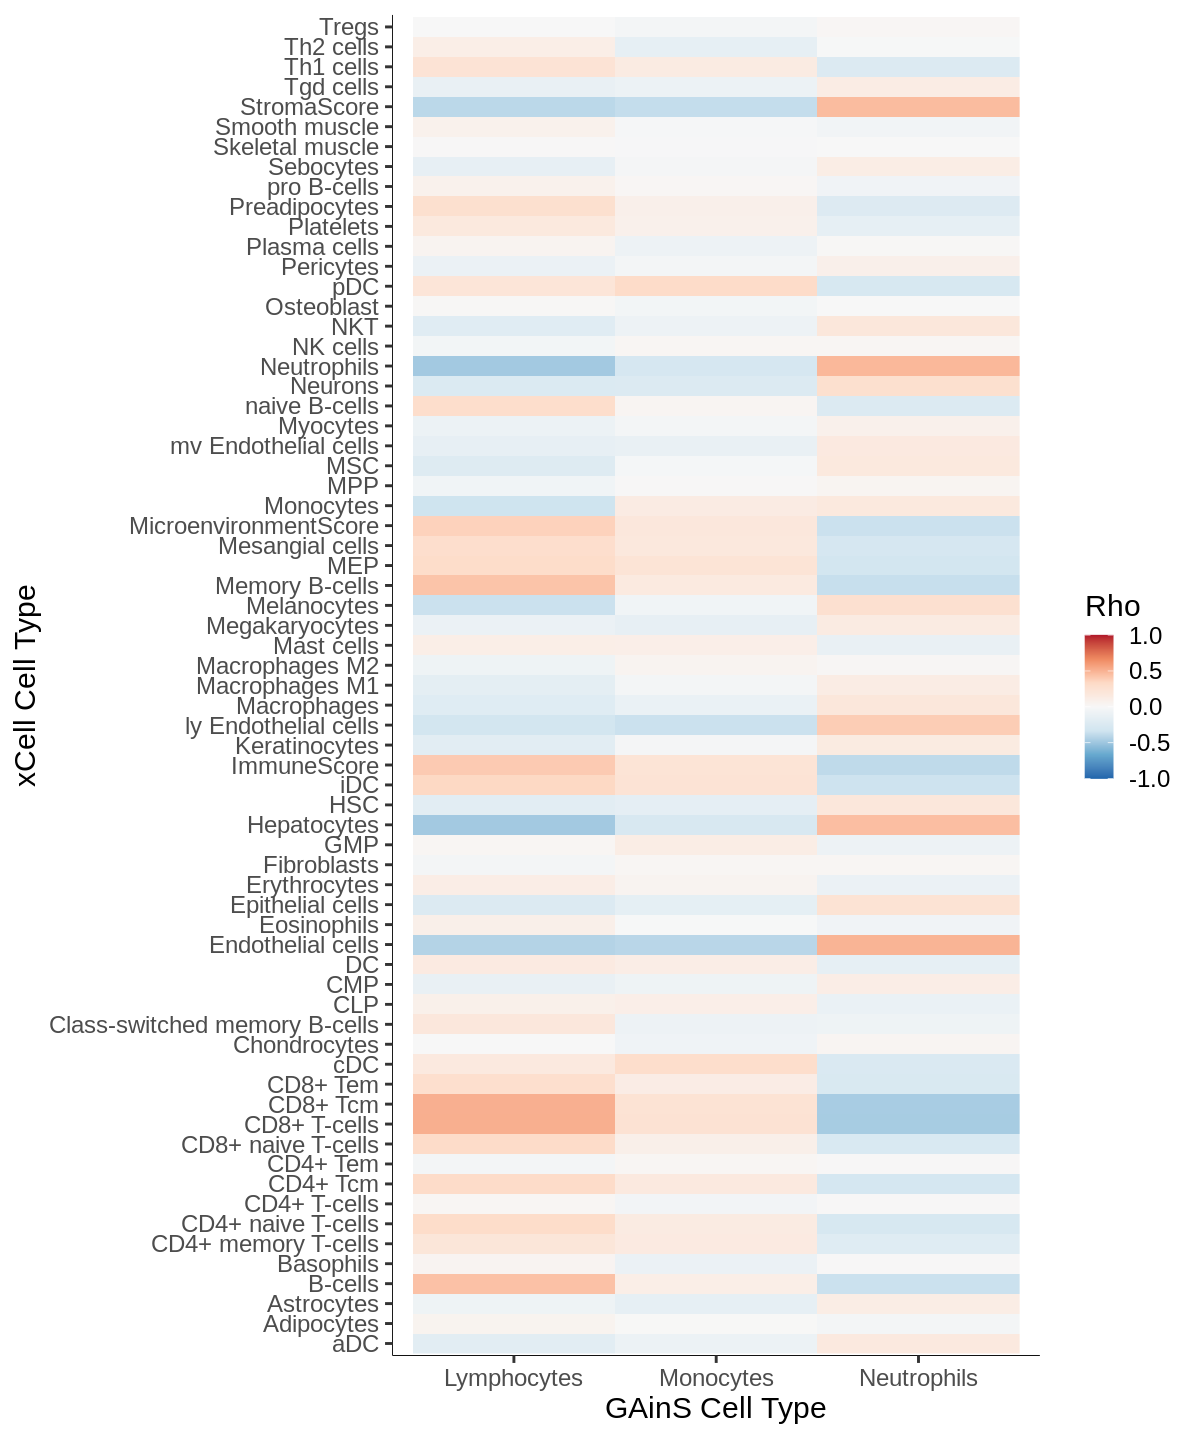

In [58]:
xcell.vars <- t(xcell.analysis)

estimates <- lapply(colnames(cell.prop.vars), function(gains.name) {
  lapply(colnames(xcell.vars), function(xcell.name) {
    test.result = cor.test(cell.prop.vars[,gains.name], xcell.vars[,xcell.name], alternative="two.sided", method="spearman", exact=FALSE)
    return(c(test.result$estimate, test.result$p.value, xcell.name))
  }) %>%
    do.call(rbind, .) %>%
    as.data.frame() %>%
    dplyr::mutate(GAinS.Cell.Type=gains.name) %>%
    dplyr::select(GAinS.Cell.Type, xCell.Cell.Type=3, Rho=1, P.Value=2) %>%
    dplyr::mutate(Rho=as.numeric(Rho), P.Value=as.numeric(P.Value))
}) %>%
  do.call(rbind, .) %>%
  as.data.frame() %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::mutate(Significance=ifelse(Adjusted.P.Value < 0.05, "*", ""))

options(repr.plot.width=10, repr.plot.height=12)
ggplot(estimates) +
  geom_raster(aes(x=GAinS.Cell.Type, y=xCell.Cell.Type, fill=Rho)) +
  scale_fill_distiller(palette="RdBu", limits=c(-1, 1)) +
  xlab("GAinS Cell Type") + ylab("xCell Cell Type") +
  ggplot_theme +
  theme(legend.position="right")
ggsave("04_Expression/results/cell_type_prop_xcell_association.svg", width=10, height=12)

As done previously, I also tested for significant associations between module eigengenes and xCell scores using Spearman's $\rho$ with p-values adjusted using the Benjamini-Hochberg FDR correction.

In [94]:
estimates <- lapply(colnames(eigengenes), function(eigengene.name) {
  lapply(colnames(xcell.vars), function(xcell.name) {
    test.result = cor.test(eigengenes[,eigengene.name], xcell.vars[,xcell.name], alternative="two.sided", method="spearman", exact=FALSE)
    return(c(abs(test.result$estimate), test.result$p.value, xcell.name))
  }) %>%
    do.call(rbind, .) %>%
    as.data.frame() %>%
    dplyr::mutate(Eigengene=eigengene.name) %>%
    dplyr::select(Eigengene, xCell.Cell.Type=3, Rho=1, P.Value=2) %>%
    dplyr::mutate(Rho=as.numeric(Rho), P.Value=as.numeric(P.Value))
}) %>%
  do.call(rbind, .) %>%
  as.data.frame() %>%
  dplyr::select(Rho, P.Value, Association.Variable=xCell.Cell.Type, Eigengene) %>%
  dplyr::mutate(Rho=as.numeric(Rho), P.Value=as.numeric(P.Value)) %>%
  dplyr::arrange(desc(abs(Rho))) %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::mutate(Association.Variable.Type="xCell Score", Statistic.Type="Rho") %>%
  dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=Rho, Statistic.Type, P.Value, Adjusted.P.Value)

write.csv(estimates, "~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.xcell.score.association.csv")

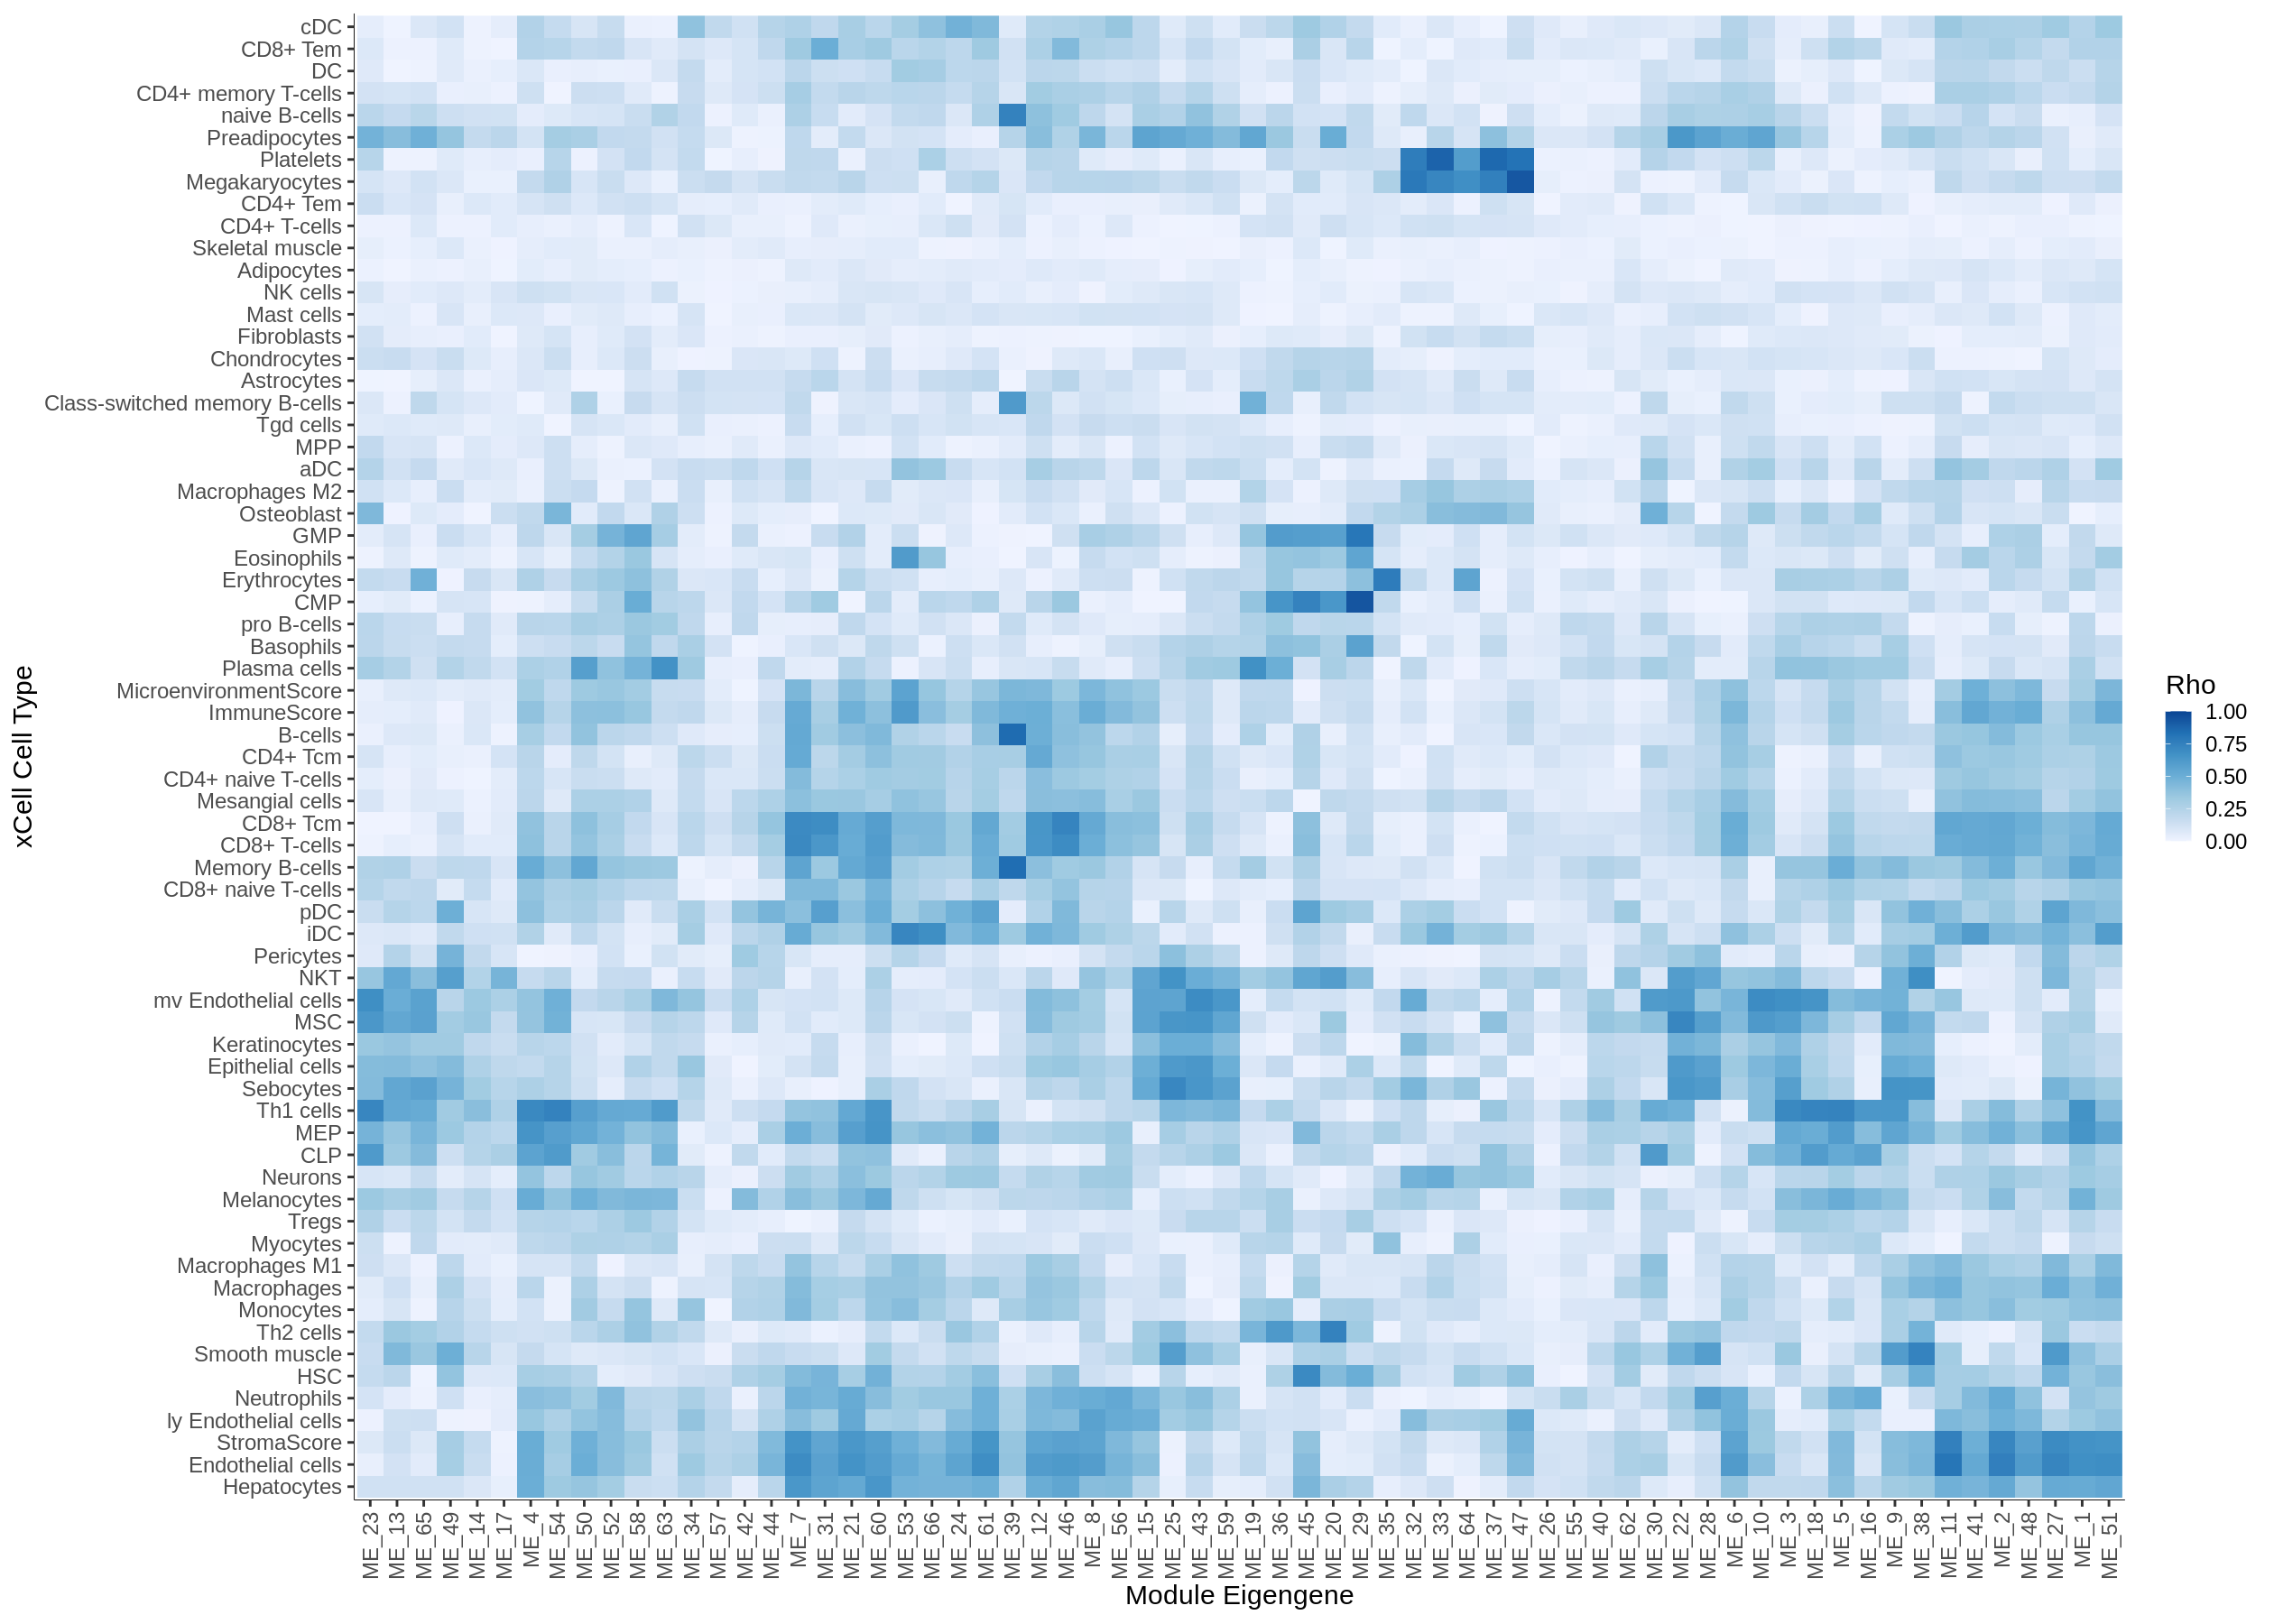

In [95]:
estimates <- estimates %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::mutate(Significance=ifelse(Adjusted.P.Value < 0.05, "*", "")) %>%
  dplyr::select(xCell.Cell.Type=Association.Variable, Rho=Statistic, everything())

cor.mtx <- cor(eigengenes, xcell.vars, method="spearman")
eigengenes.h <- hclust(dist(cor.mtx))
cell.types.h <- hclust(dist(t(cor.mtx)))
plot.data <- estimates %>%
  dplyr::mutate(Eigengene=factor(Eigengene, levels=colnames(eigengenes)[eigengenes.h$order])) %>%
  dplyr::mutate(xCell.Cell.Type=factor(xCell.Cell.Type, levels=colnames(xcell.vars)[cell.types.h$order]))

options(repr.plot.width=21, repr.plot.height=15)
ggplot(plot.data) +
  geom_raster(aes(x=Eigengene, y=xCell.Cell.Type, fill=Rho)) +
  scale_fill_distiller(palette="Blues", limits=c(0, 1), direction=1) +
  xlab("Module Eigengene") + ylab("xCell Cell Type") +
  ggplot_theme +
  theme(legend.position="right", axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))
ggsave("04_Expression/results/eigengene_xcell_association.svg", width=21, height=15)

## Overrepresentation Analysis with xCell Signatures

xCell enrichment scores are defined based on cell signatures (sets of genes associated with each primary cell type). We can test if any of these signatures are enriched in our modules. Depending on which dataset was used to derive the signature, the xCell list is slightly different. I test for overrepresentation in all signatures independently. For example, I would test for enrichment in all the different neutrophil signatures present in xCell.

I use Fisher's exact test (which is equivalent to a hypergeometric test with a one-sided alternative). The p-values are adjusted using Benjamini-Hochberg FDR correction. I report the mean, minimum, and maximum odds ratio for significant associations from a given cell type. For example, I would report the mean/medium/maximum odds ratio for the different neutrophil signatures.

In [61]:
# Reduce Modules to Genes with Gene Names
modules.list <- modules %>%
  dplyr::filter(Gene %in% gene.map$Ensembl.ID) %>%
  merge(., gene.map, by.x="Gene", by.y="Ensembl.ID") %>%
  dplyr::select(Gene=gene_name, Module) %>%
  split(., .$Module)

# Perform Overrepresentation Test

signature.cell.types <- sapply(strsplit(names(xCell.data$signatures), "%"), function(x) x[1])
unique.cell.types <- unique(signature.cell.types)

gene.lists <- list()

for (cell.type in unique.cell.types) {
  n.signatures = sum(signature.cell.types == cell.type)
  gene.lists[[cell.type]] = lapply(1:n.signatures, function(i) {
    xCell.data$signatures[signature.cell.types == cell.type][[i]]@geneIds
  })
}

ora.results <- list()
ora.results[["Module"]] <- list()
ora.results[["Cell.Type"]] <- list()
ora.results[["Odds.Ratio"]] <- list()
ora.results[["P.Value"]] <- list()
counter <- 0

for (module in names(modules.list)) {

  for (cell.type in unique.cell.types) {
  
    for (i in 1:length(gene.lists[[cell.type]])) {
      
      counter <- counter + 1
      
      gene.list = gene.lists[[cell.type]][[i]]
      module.list = modules.list[[module]]$Gene
      
      within.module.and.gene.set = length(intersect(gene.list, module.list))
      within.module.outside.gene.set = length(module.list) - within.module.and.gene.set
      outside.module.within.gene.set = length(intersect(gene.list, setdiff(gene.map$gene_name, module.list)))
      outside.module.outside.gene.set = length(setdiff(gene.map$gene_name, module.list)) - outside.module.within.gene.set
      
      contingency.mtx = data.frame(
        within.module=c(within.module.and.gene.set, within.module.outside.gene.set),
        outside.module=c(outside.module.within.gene.set, outside.module.outside.gene.set)
      )
      rownames(contingency.mtx) = c("within.gene.set", "outside.gene.set")
      test.result = fisher.test(contingency.mtx, alternative="greater")
      
      ora.results[["Module"]][[counter]] <- module
      ora.results[["Cell.Type"]][[counter]] <- cell.type
      ora.results[["Odds.Ratio"]][[counter]] <- test.result$estimate
      ora.results[["P.Value"]][[counter]] <- test.result$p.value
    }
  }
}

ora.results.df <- as.data.frame(lapply(ora.results, unlist))

filtered.cell.type.enrichment <- ora.results.df %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::filter(Adjusted.P.Value < 0.05) %>%
  dplyr::group_by(Module, Cell.Type) %>%
  dplyr::summarize(Mean.Odds.Ratio=mean(Odds.Ratio), Odds.Ratio.Min=min(Odds.Ratio), Odds.Ratio.Max=max(Odds.Ratio)) %>%
  dplyr::arrange(Module, desc(Mean.Odds.Ratio))

write.csv(filtered.cell.type.enrichment, "~/gains_team282/nikhil/expression/gene_expression/module.xcell.signature.enrichment.csv")

`summarise()` has grouped output by 'Module'. You can override using the `.groups` argument.


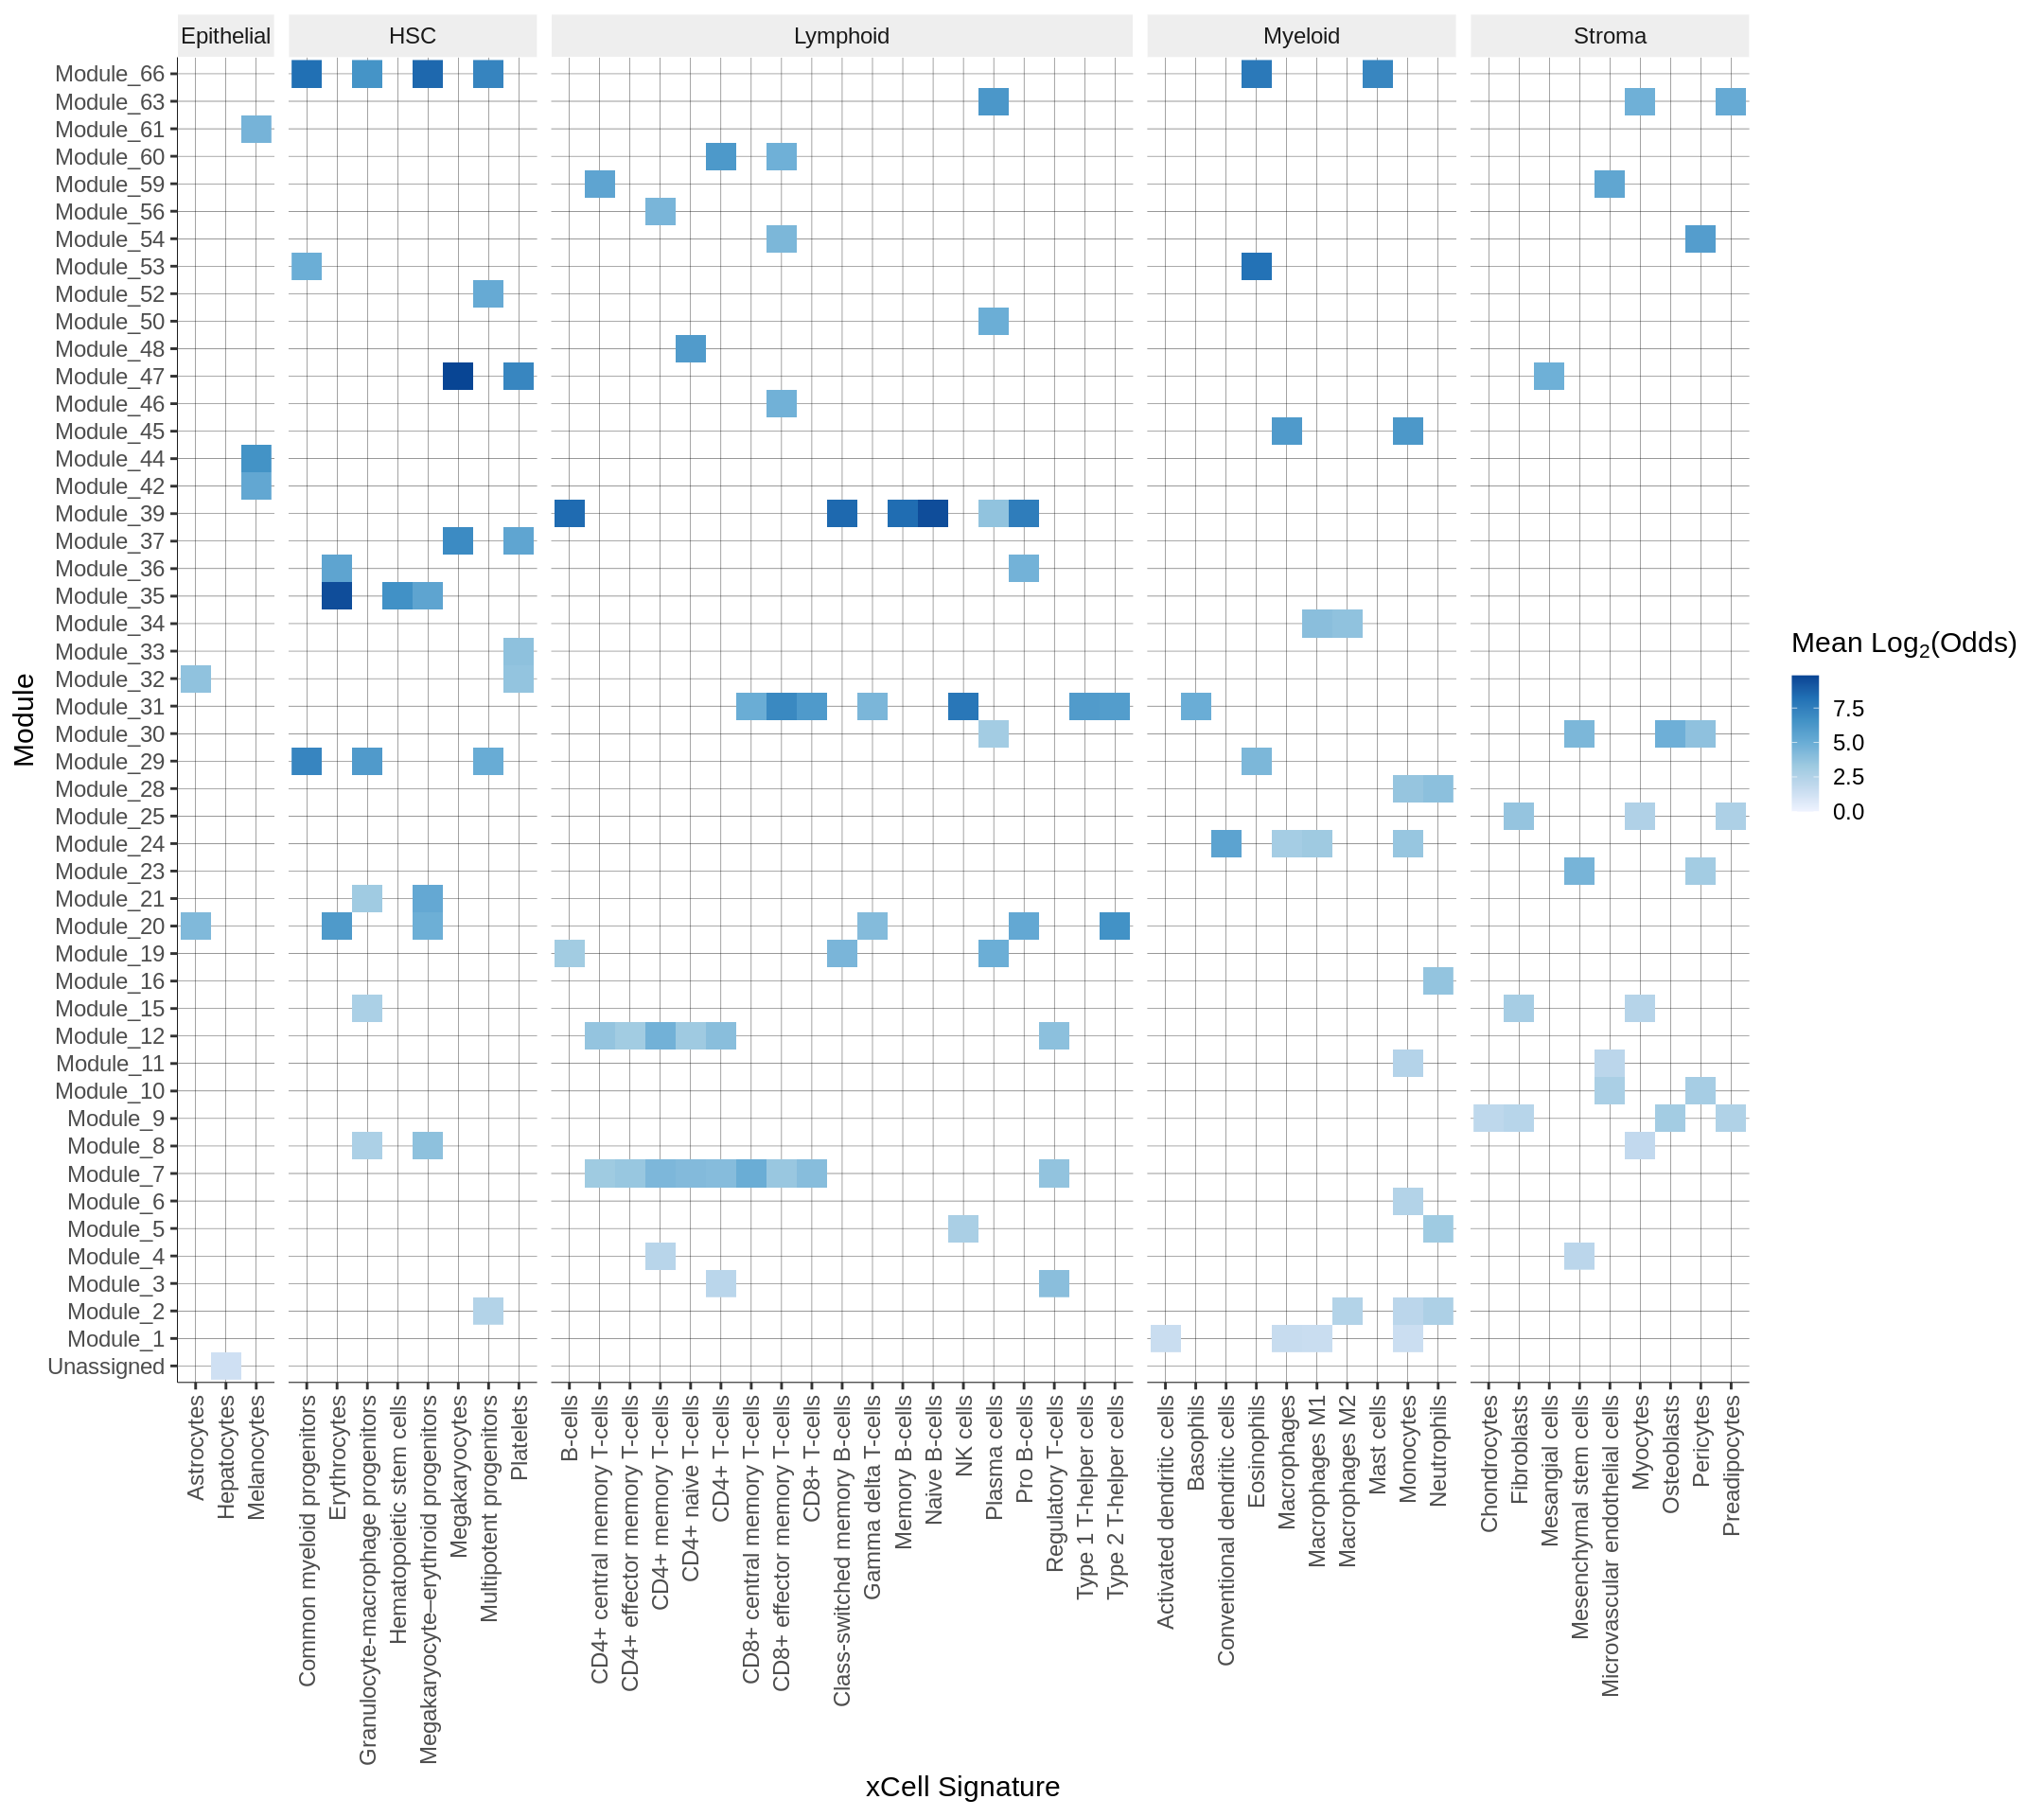

In [102]:
plot.data <- filtered.cell.type.enrichment %>%
    dplyr::mutate(Mean.Log.2.Odds=log2(Mean.Odds.Ratio)) %>%
    dplyr::mutate(Module=factor(Module, levels=c("Unassigned", paste0("Module_", 1:ncol(eigengenes)))))

options(repr.plot.width=18, repr.plot.height=16)

merge(plot.data, xcell.info, by.x="Cell.Type", by.y="Cell.types") %>%
    ggplot() +
    geom_raster(aes(x=Full.name, y=Module, fill=Mean.Log.2.Odds)) +
    scale_fill_distiller(palette="Blues", direction=1, limits=c(0, max(plot.data$Mean.Log.2.Odds))) +
    xlab("xCell Signature") + ylab("Module") +
    labs(fill=bquote("Mean Log"[2]*"(Odds)")) +
    facet_grid(.~Subgroup, scales="free_x", space="free_x") +
    ggplot_theme +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), legend.position="right", panel.grid.major=element_line(size=0.1))

ggsave("04_Expression/results/module_xcell_signature_enrichment.svg", width=18, height=16)